In [2]:
import sys

assert sys.version_info >= (3, 7)

from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

import matplotlib.pyplot as plt

import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

import sys
# 나눔 폰트를 사용합니다.
import matplotlib 

matplotlib.rc('font', family='AppleGothic')
matplotlib.rcParams['axes.unicode_minus'] = False

from pathlib import Path
import os

GRAPHS_PATH = Path(os.getcwd()).resolve().parent.parent.joinpath("data", "graphs","ch_14ㄴ")
GRAPHS_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = GRAPHS_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
from sklearn.datasets import load_sample_images

images = load_sample_images()["images"]
images = tf.keras.layers.CenterCrop(height=70, width=120)(images)
images = tf.keras.layers.Rescaling(scale=1/255)(images)

2023-11-29 09:28:44.200809: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2023-11-29 09:28:44.200832: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-29 09:28:44.200838: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-11-29 09:28:44.201233: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-29 09:28:44.201556: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
images.shape

TensorShape([2, 70, 120, 3])

In [6]:
tf.random.set_seed(42)
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7)
fmaps = conv_layer(images)

In [7]:
fmaps.shape

TensorShape([2, 64, 114, 32])

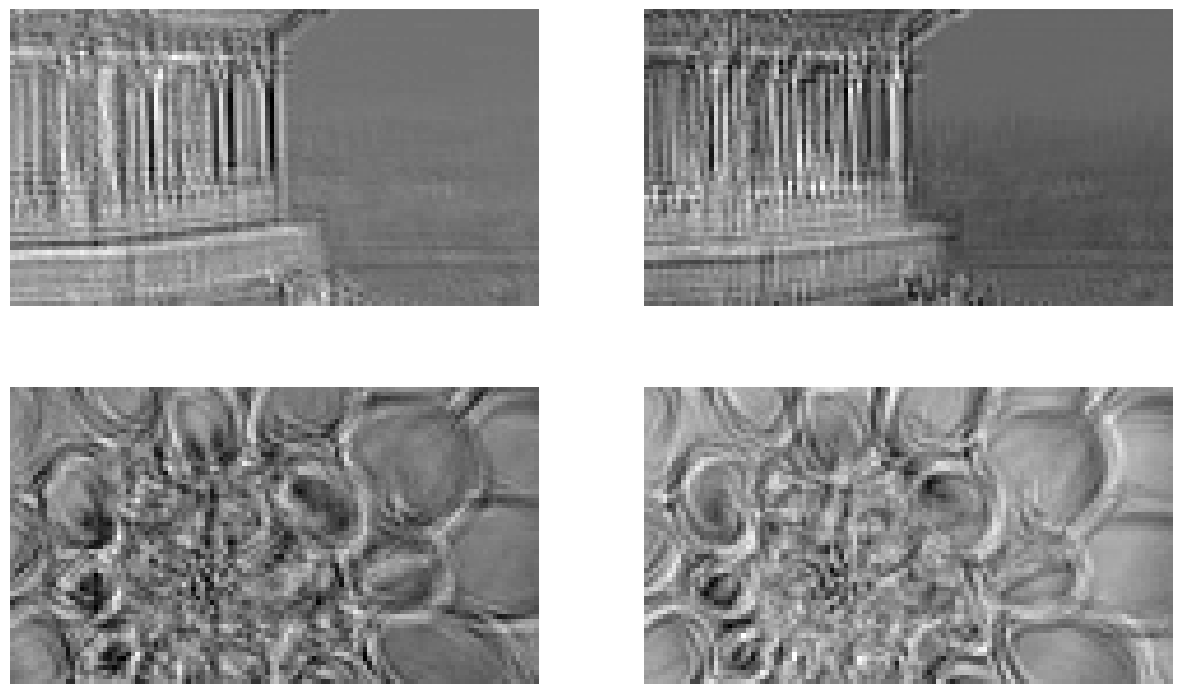

In [8]:
plt.figure(figsize=(15, 9))
for image_idx in (0, 1):
    for fmap_idx in (0, 1):
        plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap="gray")
        plt.axis("off")

plt.show()

In [12]:
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7, padding="same")
fmaps = conv_layer(images)

In [13]:
fmaps.shape

TensorShape([2, 70, 120, 32])

In [14]:
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7, padding="same", strides=2)
fmaps = conv_layer(images)
fmaps.shape

TensorShape([2, 35, 60, 32])

In [15]:
import numpy as np

def conv_output_size(input_size, kernel_size, strides=1, padding="valid"):
    if padding=="valid":
        z = input_size - kernel_size + strides
        output_size = z // strides
        num_ignored = z % strides
        return output_size, num_ignored
    else:
        output_size = (input_size - 1) // strides + 1
        num_padded = (output_size - 1) * strides + kernel_size - input_size
        return output_size, num_padded
    
conv_output_size(np.array([70, 120]), kernel_size=7, strides=2, padding="same")
    

(array([35, 60]), array([5, 5]))

In [18]:
kernels, biases = conv_layer.get_weights()
print(kernels.shape)
print(biases.shape)

(7, 7, 3, 32)
(32,)


In [20]:
tf.random.set_seed(42)
filters = tf.random.normal([7, 7, 3, 2])
biases = tf.zeros([2])
fmaps = tf.nn.conv2d(images, filters, strides=1, padding="SAME") + biases

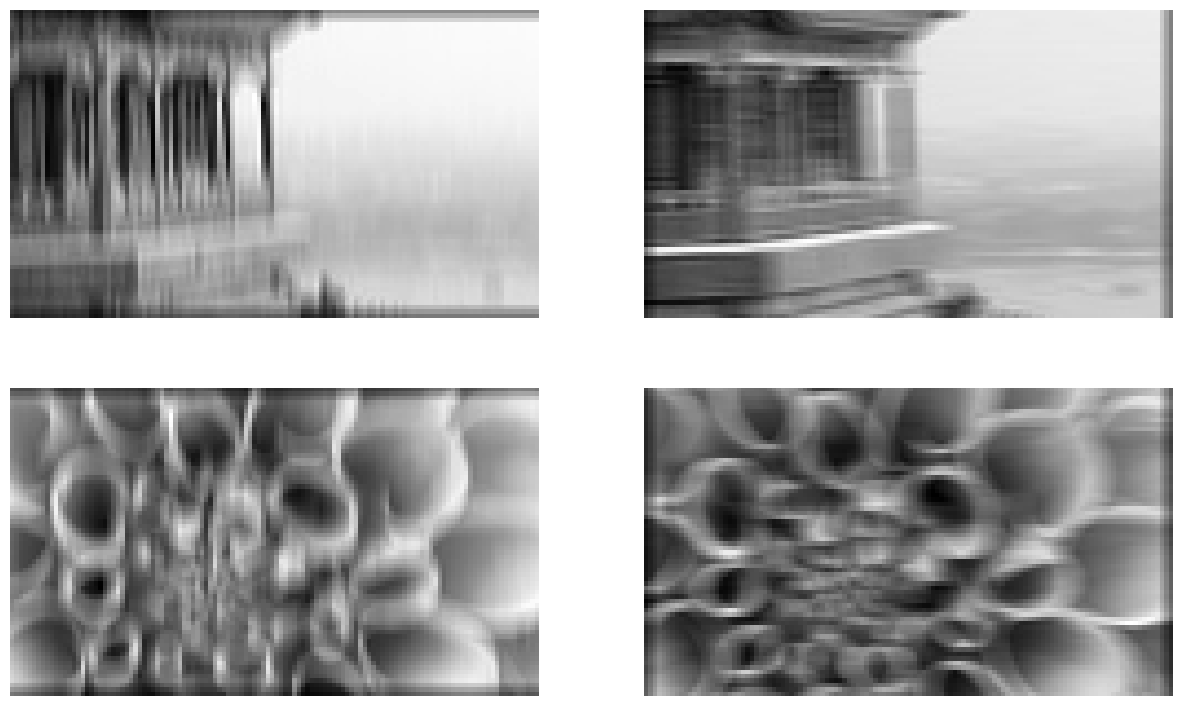

In [21]:
plt.figure(figsize=(15, 9))
filters = np.zeros([7, 7, 3, 2])
filters[:, 3, :, 0] = 1
filters[3, :, :, 1] = 1
fmaps = tf.nn.conv2d(images, filters, strides=1, padding="SAME") + biases

for image_idx in (0, 1):
    for fmap_idx in (0, 1):
        plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap="gray")
        plt.axis("off")

plt.show()

In [24]:
max_pool = tf.keras.layers.MaxPool2D(pool_size=2)

In [25]:
output = max_pool(images)

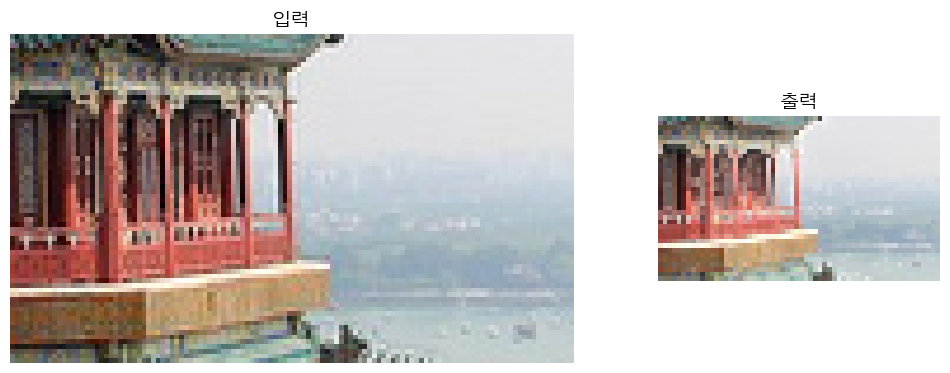

In [26]:
import matplotlib as mpl

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("입력")
ax1.imshow(images[0])
ax1.axis("off")
ax1 = fig.add_subplot(gs[0, 1])
ax1.set_title("출력")
ax1.imshow(output[0])
ax1.axis("off")
plt.show()

In [27]:
np.random.seed(42)
fmaps = np.random.rand(2, 70, 120, 60)
with tf.device("/cpu:0"):
    output = tf.nn.max_pool(fmaps, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3), padding="VALID")

output.shape

TensorShape([2, 70, 120, 20])

In [29]:
class DepthPool(tf.keras.layers.Layer):
    def __init__(self, pool_size=2, **kwargs):
        super().__init__(**kwargs)
        self.pool_size = pool_size

    def call(self, inputs):
        shape = tf.shape(inputs)
        groups = shape[-1] // self.pool_size
        new_shape = tf.concat([shape[:-1], [groups, self.pool_size]], axis=0)
        return tf.reduce_max(tf.reshape(inputs, new_shape), axis=-1)

In [30]:
np.allclose(DepthPool(pool_size=3)(fmaps), output)

True

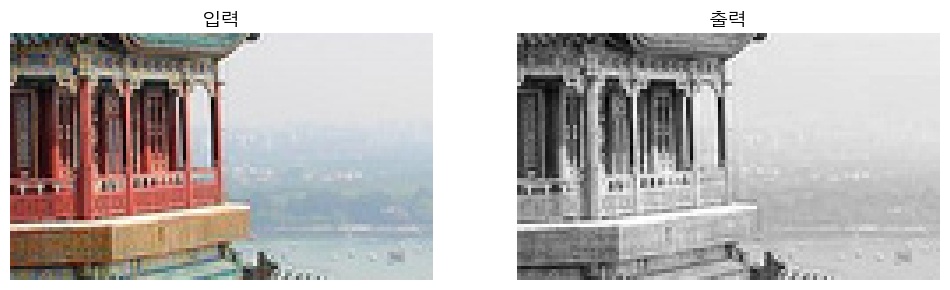

In [31]:
depth_output = DepthPool(pool_size=3)(images)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("입력")
plt.imshow(images[0])
plt.axis("off")
plt.subplot(1, 2, 2)
plt.title("출력")
plt.imshow(depth_output[0, ..., 0], cmap="gray")
plt.axis("off")
plt.show()

In [33]:
global_avg_pool = tf.keras.layers.GlobalAvgPool2D()

gloval_avg_pool = tf.keras.layers.Lambda(
    lambda X: tf.reduce_mean(X, axis=[1, 2])
)
global_avg_pool(images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.64338803, 0.5971821 , 0.58250374],
       [0.76307476, 0.26010883, 0.10848834]], dtype=float32)>

In [34]:
mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = mnist
X_train_full = np.expand_dims(X_train_full, axis=-1).astype(np.float32) / 255
X_test = np.expand_dims(X_test.astype(np.float32), axis=-1) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [37]:
from functools import partial

tf.random.set_seed(42)
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding="same",
                        activation="relu", kernel_initializer="he_normal")
model = tf.keras.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=10, activation="softmax")
])

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10]
y_pred = model.predict(X_new)

In [44]:
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, strides=1, padding="same",
                        kernel_initializer="he_normal", use_bias=False)

class ResidualUnit(tf.keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            tf.keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            tf.keras.layers.BatchNormalization()
        ]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                tf.keras.layers.BatchNormalization()
            ]
    
    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [45]:
model = tf.keras.Sequential([
    DefaultConv2D(64, kernel_size=7, strides=2, input_shape=[224, 224, 3]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same")
])
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters

model.add(tf.keras.layers.GlobalAvgPool2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [46]:
model = tf.keras.applications.ResNet50(weights="imagenet")

102967424/102967424 [==============================] - 9s 0us/step


In [47]:
images = load_sample_images()["images"]
images_resized = tf.keras.layers.Resizing(height=224, width=224,
                                          crop_to_aspect_ratio=True)(images)

In [48]:
inputs = tf.keras.applications.resnet50.preprocess_input(images_resized)

Y_proba = model.predict(inputs)
Y_proba.shape

1/1 [==============================] - 2s 2s/step


(2, 1000)

In [49]:
top_K = tf.keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print(f"이미지 #{image_idx}")
    for class_id, name, y_proba in top_K[image_index]:
        print(f"  {class_id} - {name:12s} {y_proba:.2%}")

35363/35363 [==============================] - 0s 0us/step
이미지 #1
  n03877845 - palace       54.69%
  n03781244 - monastery    24.72%
  n02825657 - bell_cote    18.55%
이미지 #1
  n04522168 - vase         32.66%
  n11939491 - daisy        17.81%
  n03530642 - honeycomb    12.06%


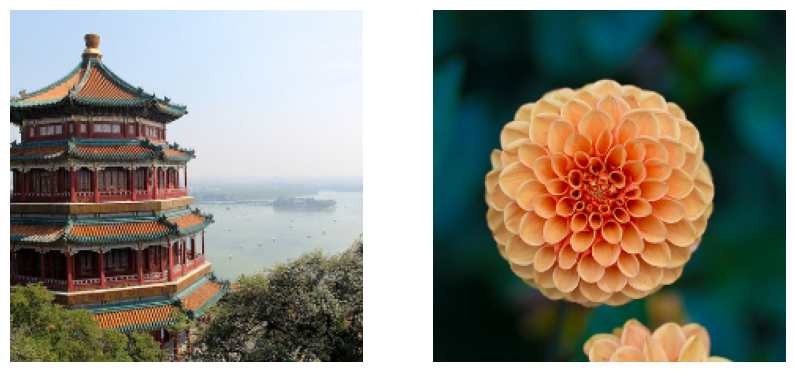

In [50]:
plt.figure(figsize=(10, 6))
for idx in (0, 1):
    plt.subplot(1, 2, idx + 1)
    plt.imshow(images_resized[idx] / 255)
    plt.axis("off")

plt.show()

In [52]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
dataset_size = info.splits["train"].num_examples
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes

In [53]:
dataset_size

3670

In [54]:
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [55]:
n_classes

5

In [56]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True
)

2023-11-29 14:06:51.848503: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


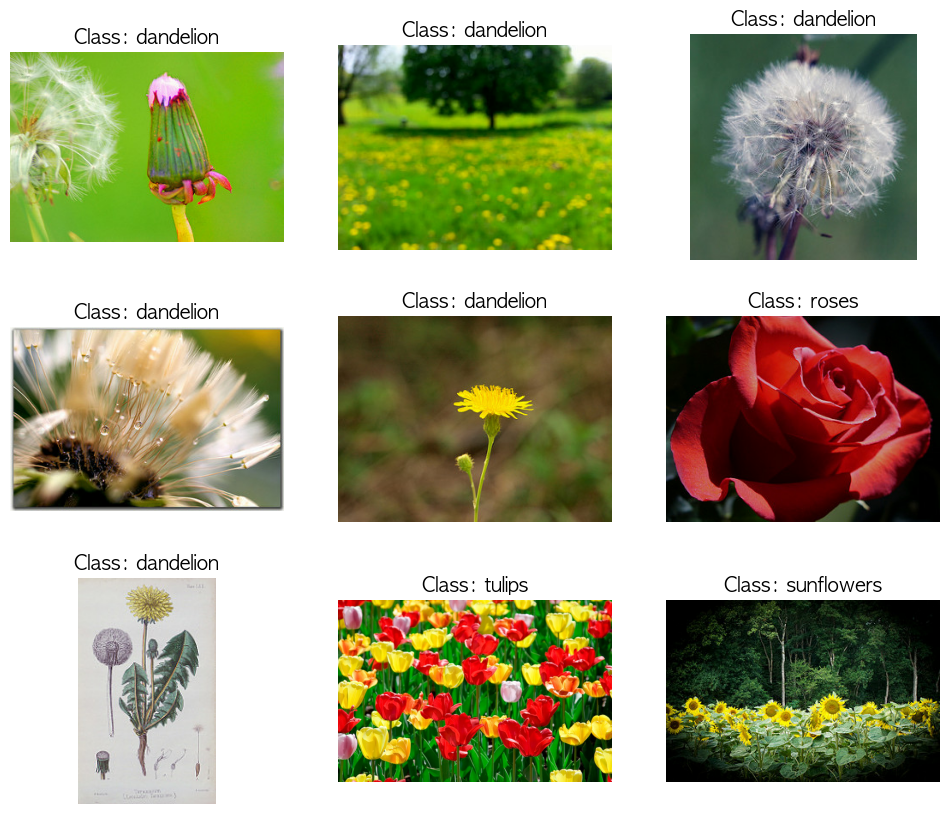

In [57]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in valid_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title(f"Class: {class_names[label]}")
    plt.axis("off")

plt.show()

In [58]:
tf.keras.backend.clear_session()

batch_size = 32
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
    tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input)
])
train_set = train_set_raw.map(lambda X, y: (preprocess(X), y))
train_set = train_set.shuffle(1000, seed=42).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)
test_set = test_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)

2023-11-29 14:14:17.762543: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


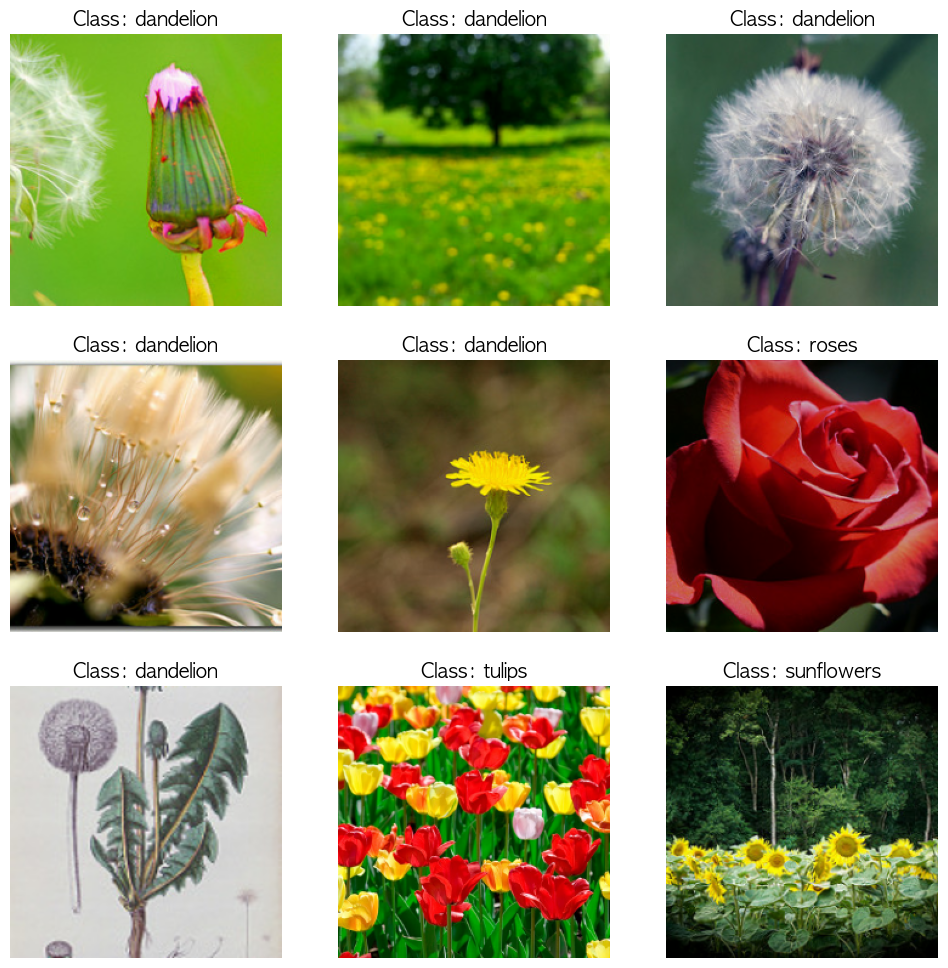

In [59]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow((X_batch[index] + 1) / 2)
        plt.title(f"Class: {class_names[y_batch[index]]}")
        plt.axis("off")

plt.show()

In [63]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal", seed=42),
    tf.keras.layers.RandomRotation(factor=0.05, seed=42),
    tf.keras.layers.RandomContrast(factor=0.2, seed=42),
])

2023-11-29 14:36:04.015120: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-11-29 14:36:04.132974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-29 14:36:04.500995: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


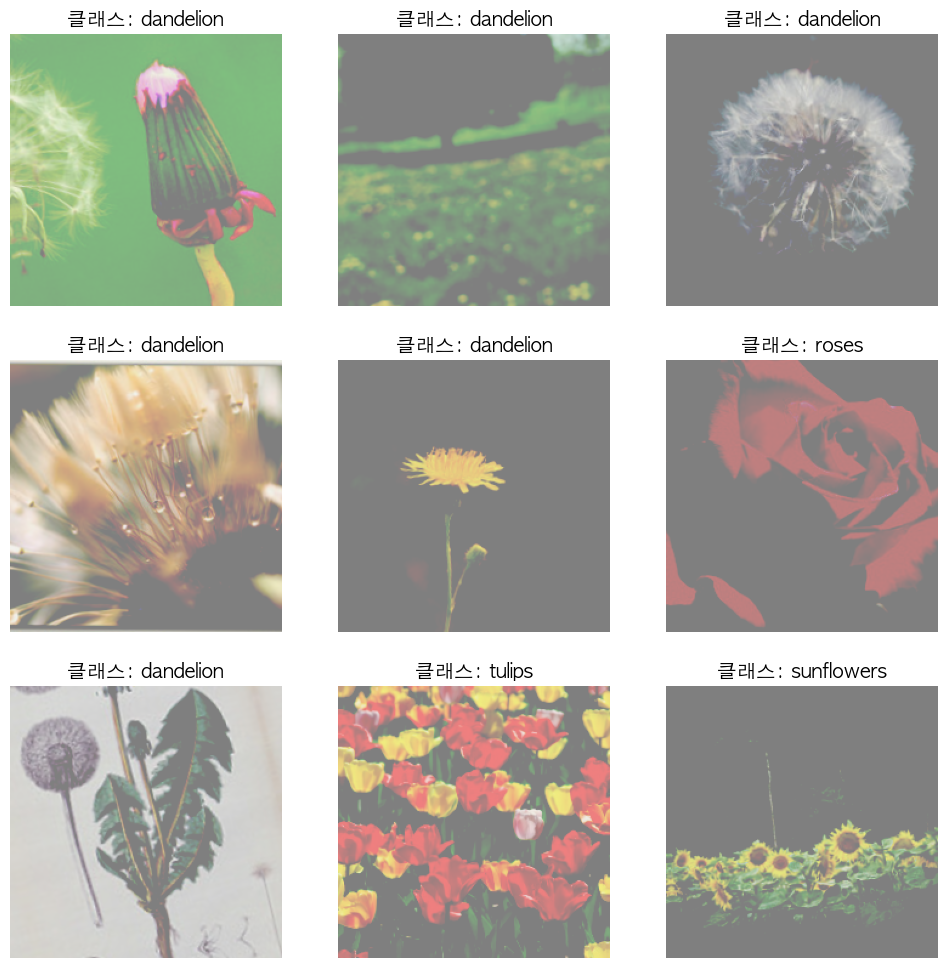

In [64]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    X_batch_augmented = data_augmentation(X_batch, training=True)
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(np.clip((X_batch_augmented[index] + 1) / 2, 0, 1))
        plt.title(f"클래스: {class_names[y_batch[index]]}")
        plt.axis("off")

plt.show()

In [66]:
tf.random.set_seed(42)
base_model = tf.keras.applications.xception.Xception(weights="imagenet", include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

In [67]:
for layer in base_model.layers:
    layer.trainable = False

In [68]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=3)

Epoch 1/3


2023-11-29 15:27:00.922878: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node SGD/AssignVariableOp.


86/86 [==============================] - 37s 397ms/step - loss: 0.7652 - accuracy: 0.8052 - val_loss: 0.7333 - val_accuracy: 0.8421
Epoch 2/3
86/86 [==============================] - 33s 384ms/step - loss: 0.3325 - accuracy: 0.9092 - val_loss: 0.5708 - val_accuracy: 0.8512
Epoch 3/3
86/86 [==============================] - 33s 379ms/step - loss: 0.1697 - accuracy: 0.9404 - val_loss: 0.7334 - val_accuracy: 0.8566


In [69]:
for indices in zip(range(33), range(33, 66), range(66, 99), range(99, 132)):
    for idx in indices:
        print(f"{idx:3}: {base_model.layers[idx].name:22}", end="")
    print()

  0: input_2                33: block4_pool            66: block8_sepconv1_act    99: block11_sepconv2_act  
  1: block1_conv1           34: batch_normalization_6  67: block8_sepconv1       100: block11_sepconv2      
  2: block1_conv1_bn        35: add_14                 68: block8_sepconv1_bn    101: block11_sepconv2_bn   
  3: block1_conv1_act       36: block5_sepconv1_act    69: block8_sepconv2_act   102: block11_sepconv3_act  
  4: block1_conv2           37: block5_sepconv1        70: block8_sepconv2       103: block11_sepconv3      
  5: block1_conv2_bn        38: block5_sepconv1_bn     71: block8_sepconv2_bn    104: block11_sepconv3_bn   
  6: block1_conv2_act       39: block5_sepconv2_act    72: block8_sepconv3_act   105: add_21                
  7: block2_sepconv1        40: block5_sepconv2        73: block8_sepconv3       106: block12_sepconv1_act  
  8: block2_sepconv1_bn     41: block5_sepconv2_bn     74: block8_sepconv3_bn    107: block12_sepconv1      
  9: block2_sepconv

In [70]:
for layer in base_model.layers:
    layer.trainable = False

In [71]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=3)

Epoch 1/3


2023-11-29 15:30:27.627020: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node SGD/AssignVariableOp.


86/86 [==============================] - 35s 386ms/step - loss: 0.0967 - accuracy: 0.9633 - val_loss: 0.5313 - val_accuracy: 0.8784
Epoch 2/3
86/86 [==============================] - 33s 386ms/step - loss: 0.0592 - accuracy: 0.9804 - val_loss: 0.5576 - val_accuracy: 0.8820
Epoch 3/3
86/86 [==============================] - 33s 385ms/step - loss: 0.0605 - accuracy: 0.9822 - val_loss: 0.6289 - val_accuracy: 0.8566


In [72]:
for indices in zip(range(33), range(33, 66), range(66, 99), range(99, 132)):
    for idx in indices:
        print(f"{idx:3}: {base_model.layers[idx].name:22}", end="")
    print()

  0: input_2                33: block4_pool            66: block8_sepconv1_act    99: block11_sepconv2_act  
  1: block1_conv1           34: batch_normalization_6  67: block8_sepconv1       100: block11_sepconv2      
  2: block1_conv1_bn        35: add_14                 68: block8_sepconv1_bn    101: block11_sepconv2_bn   
  3: block1_conv1_act       36: block5_sepconv1_act    69: block8_sepconv2_act   102: block11_sepconv3_act  
  4: block1_conv2           37: block5_sepconv1        70: block8_sepconv2       103: block11_sepconv3      
  5: block1_conv2_bn        38: block5_sepconv1_bn     71: block8_sepconv2_bn    104: block11_sepconv3_bn   
  6: block1_conv2_act       39: block5_sepconv2_act    72: block8_sepconv3_act   105: add_21                
  7: block2_sepconv1        40: block5_sepconv2        73: block8_sepconv3       106: block12_sepconv1_act  
  8: block2_sepconv1_bn     41: block5_sepconv2_bn     74: block8_sepconv3_bn    107: block12_sepconv1      
  9: block2_sepconv

In [73]:
for layer in base_model.layers[56:]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=10)

Epoch 1/10


2023-11-29 15:33:50.426919: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node SGD/AssignVariableOp.


86/86 [==============================] - 70s 757ms/step - loss: 0.2798 - accuracy: 0.9030 - val_loss: 0.4212 - val_accuracy: 0.8929
Epoch 2/10
86/86 [==============================] - 65s 750ms/step - loss: 0.0379 - accuracy: 0.9880 - val_loss: 0.4345 - val_accuracy: 0.9129
Epoch 3/10
86/86 [==============================] - 65s 754ms/step - loss: 0.0277 - accuracy: 0.9927 - val_loss: 0.3667 - val_accuracy: 0.9093
Epoch 4/10
86/86 [==============================] - 64s 746ms/step - loss: 0.0176 - accuracy: 0.9938 - val_loss: 0.3798 - val_accuracy: 0.9056
Epoch 5/10
86/86 [==============================] - 65s 754ms/step - loss: 0.0051 - accuracy: 0.9985 - val_loss: 0.3434 - val_accuracy: 0.9074
Epoch 6/10
86/86 [==============================] - 65s 751ms/step - loss: 0.0028 - accuracy: 0.9996 - val_loss: 0.3598 - val_accuracy: 0.9147
Epoch 7/10
86/86 [==============================] - 65s 750ms/step - loss: 0.0029 - accuracy: 0.9993 - val_loss: 0.3728 - val_accuracy: 0.9129
Epoch 8/10

In [74]:
tf.random.set_seed(42)
base_model = tf.keras.applications.xception.Xception(weights="imagenet", include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
loc_output = tf.keras.layers.Dense(4)(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=[class_output, loc_output])

optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              loss_weights=[0.8, 0.2], optimizer=optimizer, metrics=["accuracy"])

In [75]:
def add_random_bounding_boxes(images, labels):
    fake_bboxes = tf.random.uniform([tf.shape(images)[0], 4])
    return images, (labels, fake_bboxes)

fake_train_set = train_set.take(5).repeat(2).map(add_random_bounding_boxes)
model.fit(fake_train_set, epochs=2)

Epoch 1/2
10/10 [==============================] - 18s 1s/step - loss: 0.8638 - dense_2_loss: 1.0192 - dense_3_loss: 0.2423 - dense_2_accuracy: 0.5813 - dense_3_accuracy: 0.2531
Epoch 2/2
10/10 [==============================] - 12s 1s/step - loss: 0.3095 - dense_2_loss: 0.3487 - dense_3_loss: 0.1526 - dense_2_accuracy: 0.8750 - dense_3_accuracy: 0.2531


In [76]:
def maximum_precisions(precisions):
    return np.flip(np.maximum.accumulate(np.flip(precisions)))

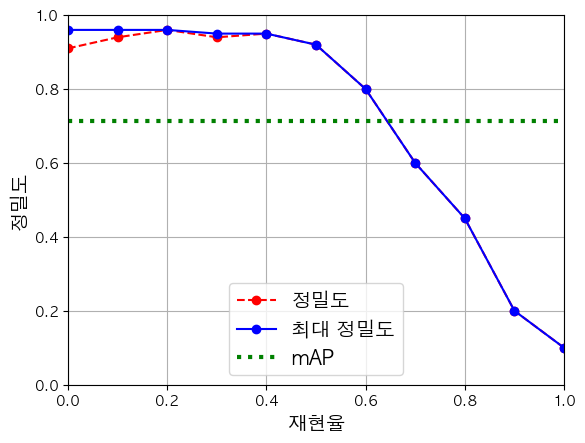

In [79]:
recalls = np.linspace(0, 1, 11)

precisions = [0.91, 0.94, 0.96, 0.94, 0.95, 0.92, 0.80, 0.60, 0.45, 0.20, 0.10]
max_precisions = maximum_precisions(precisions)
mAP = max_precisions.mean()
plt.plot(recalls, precisions, "ro--", label="정밀도")
plt.plot(recalls, max_precisions, "bo-", label="최대 정밀도")
plt.xlabel("재현율")
plt.ylabel("정밀도")
plt.plot([0, 1], [mAP, mAP], "g:", linewidth=3, label="mAP")
plt.grid(True)
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower center")
plt.show()

1. 이미지 분류에서 완전 연결 DNN보다 CNN이 나은 점은 무엇인가요?
- 부분적으로 연결되어 있으며 가중치를 공유하므로, 파라미터가 적어 훈련 속도가 빠르고 과대적합이 저하되며 적은 훈련 데이터를 필요로 함

2. 문제 확인
- 문제의 전체 파라미터 수 : 
    (커널(3x3) x 채널(3) + 편향(1)) x 아래 특성맵(100) = 2,800개
    (이전의 특성맵(100) x 커널(3x3) + 편향(1)) x 중간 특성맵(200) = 180,200개
    (이전의 특성맵(200) x 커널(3x3) + 편향(1)) x 위 특성맵(300) = 720,400개 
    총 : 2,800 +  180,200 + 720,400 = 903,400개  
- 적어도 얼마의 RAM : ?
- 50개를 미니배치로 훈련할 때는 : ?

3. 어떤 CNN 훈련 시, GPU 메모리 부족 해결 방법
- 미니배치의 크기 줄이기
- 하나 이상의층에서 스트라이드를 크게 하여 차원 감소
- 하나 이상의 층을 제거
- 32비트 부동소수 대신 16비트 부동소수 사용
- 여러 장치에 CNN 분산

4. 같은 크기의 스트라이드의 합성곱 층 대신 최대 풀링층을 추가하는 이유
- 최대 풀링층은 파리미터를 가지고 있지 않기 때문에

5. LRN 층을 추가해야 할 때는?
- 가장 강하게 활성화되는 뉴런이 이웃한 특성 맵의 동일한 위체이 있는 뉴런 억제, 특성 맵마다 특별하게 구분되어 넓은 범위 특성 탐색하도록 강제

6. 장점은?
- LeNet-5 대비 AlexNet의 장점 : 더 크고 깊으며, 합성곱층 위에 풀링층을 두지 않고 합성곱만 쌓아올림
- GoogleNet : 인셉션 모듈
- ResNet : 스킵 연결을 통해 깊은 신경망 구성
- SENet : SE블록을 통해 특성 맵의 상대적 중요도 보정
- Xception : 공간 패턴과 깊이별 패턴을 나누어보는 깊이별 분리 합성곱

7. 완전 합성곱 신경망이란, 밀집 층을 어떻게 합성곱 층으로 바꾸는 지
- 어떤 크기의 너비와 높이를 가진 이미지라도 효율적으로 처리,  

8. 시멘틱 분할에서 주요한 기술적 어려움은?
- CNN에서 신호가 층을 거쳐 전달되면서 공간상의 정보가 사라짐

In [80]:
mnist = tf.keras.datasets.mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = mnist
X_train_full = X_train_full / 255.
X_test = X_test / 255.
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

11490434/11490434 [==============================] - 1s 0us/step


In [81]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=3, padding="same",
                           activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Conv2D(64, kernel_size=3, padding="same",
                           activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(128, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
model.evaluate(X_test, y_test)

Epoch 1/10
1719/1719 [==============================] - 34s 18ms/step - loss: 0.3567 - accuracy: 0.9209 - val_loss: 0.0895 - val_accuracy: 0.9824
Epoch 2/10
1719/1719 [==============================] - 31s 18ms/step - loss: 0.2876 - accuracy: 0.9573 - val_loss: 0.1639 - val_accuracy: 0.9800
Epoch 3/10
1719/1719 [==============================] - 30s 17ms/step - loss: 0.3693 - accuracy: 0.9632 - val_loss: 0.2598 - val_accuracy: 0.9824
Epoch 4/10
1719/1719 [==============================] - 30s 17ms/step - loss: 0.5127 - accuracy: 0.9670 - val_loss: 0.2723 - val_accuracy: 0.9858
Epoch 5/10
1719/1719 [==============================] - 29s 17ms/step - loss: 0.8412 - accuracy: 0.9675 - val_loss: 0.4621 - val_accuracy: 0.9858
Epoch 6/10
1719/1719 [==============================] - 29s 17ms/step - loss: 1.3308 - accuracy: 0.9677 - val_loss: 0.5969 - val_accuracy: 0.9888
Epoch 7/10
1719/1719 [==============================] - 30s 17ms/step - loss: 2.1603 - accuracy: 0.9683 - val_loss: 1.3992 -

[4.325872898101807, 0.9840999841690063]